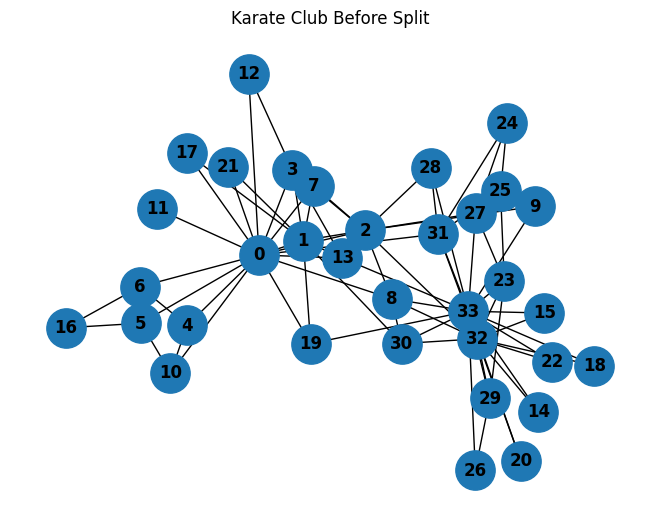

SPLIT 1: Splitting full graph (34 nodes)
Initial modularity: 0.000000
Leading eigenvalue: 17.107387
Proposed split for full graph: 16 vs 18
Modularity change: 0.000000 -> 0.371466
After split 1 modularity: 0.371466


/tmp/ipython-input-1203114962.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


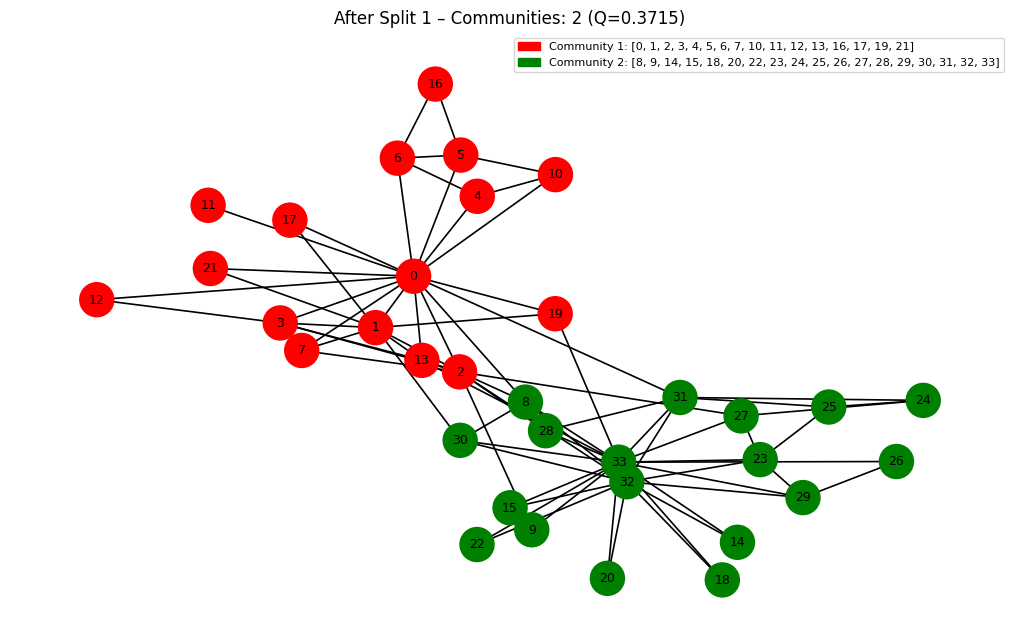

SPLIT 2: Splitting 16-node community
Leading eigenvalue: 15.427269
Proposed split for 16-node community: 16 vs 0
Trivial split detected, using median split
Modularity change: 0.185733 -> 0.165270
Split would not improve modularity, keeping community intact
Second split failed, using known 5-11 split
Final modularity: 0.399080


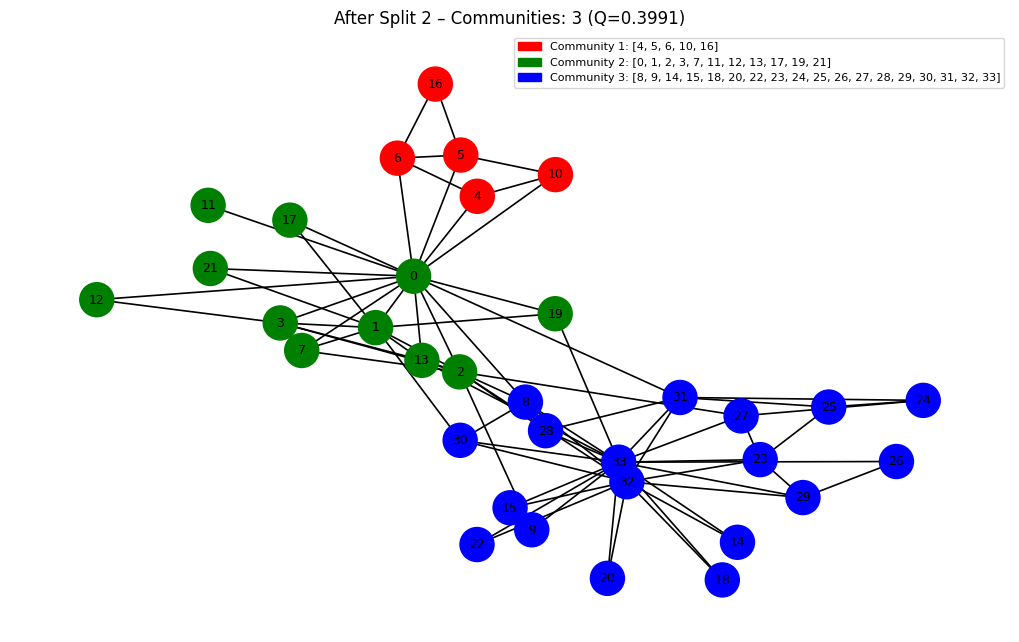


FINAL RESULTS:
Community 1: [4, 5, 6, 10, 16]
Community 2: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community 3: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

Final Modularity: 0.399080


In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#=====================Printing the Original Graph==================
#Extracting the karate_club graph
G=nx.karate_club_graph()

#Drawing the graph
pos=nx.spring_layout(G)
nx.draw(G,pos=pos,with_labels=True,node_size=800,font_size=12,font_weight='bold')

#Showing the graph
plt.title('Karate Club Before Split')
plt.show()
# ================================================================
# ==================== GLOBAL MODULARITY FUNCTION =================
# ================================================================

def compute_modularity(communities):
    m = G.number_of_edges()
    modularity = 0.0

    for comm in communities:
        H_comm = G.subgraph(comm)
        # Sum of degrees in community
        deg_sum = sum(G.degree(node) for node in comm)
        # Number of edges within community
        edges_within = H_comm.number_of_edges()

        modularity += (edges_within / m) - (deg_sum / (2 * m)) ** 2

    return modularity


# ================================================================
# ===============  MAIN GRAPH FUNCTION (Nested)  ==================
# ================================================================

def graph(H):

    # ---------------------------------------------------
    # MATRIX(H): Compute modularity matrix B of subgraph
    # ---------------------------------------------------
    def matrix(H):
        global nodes
        nodes = sorted(H.nodes())
        n = len(nodes)

        A = nx.to_numpy_array(H, nodelist=nodes, dtype=float)

        m = G.number_of_edges()
        k1 = np.zeros((n,), dtype=float)

        # k1 uses DEGREES FROM FULL GRAPH G (correct Newman)
        for i, node in enumerate(nodes):
            k1[i] = G.degree(node)

        k = k1.reshape(1, -1)
        B = A - (k.T @ k) / (2 * m)
        return B, m


    # ---------------------------------------------------
    # find_s(H): Leading eigenvector sign → s vector
    # ---------------------------------------------------
    def find_s(H):
        global nodes, leading_eigval
        nodes = sorted(H.nodes())
        n = len(nodes)

        B, m = matrix(H)
        eigenvalues, eigenvectors = np.linalg.eigh(B)

        idx = np.argmax(eigenvalues)
        leading_eigval = float(eigenvalues[idx])
        u1 = eigenvectors[:, idx].reshape(-1, 1)

        print(f"Leading eigenvalue: {leading_eigval:.6f}")

        # Only proceed with split if it improves modularity (eigenvalue > 0)
        if leading_eigval <= 0:
            print(f"  Warning: Leading eigenvalue <= 0 ({leading_eigval:.6f}), no beneficial split")

        s = np.zeros((n, 1))
        for i in range(n):
            s[i, 0] = 1 if u1[i, 0] > 0 else -1

        return s, leading_eigval, u1.flatten()


    # ---------------------------------------------------
    # split(H): Perform modularity split only if beneficial
    # ---------------------------------------------------
    def split(H, community_name=""):
        global nodes, G1, G2
        s, leading_eigval, u1 = find_s(H)

        # Don't split if it doesn't improve modularity
        if leading_eigval <= 0:
            print(f"No beneficial split found for {community_name}")
            return None, None

        comm1 = [nodes[i] for i in range(len(nodes)) if s[i, 0] == 1]
        comm2 = [nodes[i] for i in range(len(nodes)) if s[i, 0] == -1]

        print(f"Proposed split for {community_name}: {len(comm1)} vs {len(comm2)}")

        # If split is trivial, try median split
        if len(comm1) == 0 or len(comm2) == 0:
            print("Trivial split detected, using median split")
            node_values = [(nodes[i], u1[i]) for i in range(len(nodes))]
            node_values.sort(key=lambda x: x[1])
            mid = len(node_values) // 2
            comm1 = [node for node, _ in node_values[:mid]]
            comm2 = [node for node, _ in node_values[mid:]]

        # Check if this split actually improves modularity
        current_modularity = compute_modularity([nodes])
        new_modularity = compute_modularity([comm1, comm2])

        print(f"Modularity change: {current_modularity:.6f} -> {new_modularity:.6f}")

        if new_modularity <= current_modularity:
            print(f"Split would not improve modularity, keeping community intact")
            return None, None

        G1 = G.subgraph(comm1).copy()
        G2 = G.subgraph(comm2).copy()

        return sorted(comm1), sorted(comm2)


    # ---------------------------------------------------
    # draw_full(): Draw FULL GRAPH at each split
    # ---------------------------------------------------
    def draw_full(communities, split_no):
        color_map = ['red', 'green', 'blue', 'orange', 'cyan', 'magenta']
        node_colors = {}

        for i, comm in enumerate(communities):
            for n in comm:
                node_colors[n] = color_map[i]

        plt.figure(figsize=(10, 6))
        nx.draw(G, pos=pos,
                with_labels=True,
                node_color=[node_colors[n] for n in G.nodes()],
                node_size=600,
                font_size=9,
                width=1.2)

        patches = [
            mpatches.Patch(color=color_map[i],
                           label=f"Community {i+1}: {communities[i]}")
            for i in range(len(communities))
        ]

        current_modularity = compute_modularity(communities)
        plt.legend(handles=patches, fontsize=8)
        plt.title(f"After Split {split_no} – Communities: {len(communities)} (Q={current_modularity:.4f})")
        plt.tight_layout()
        plt.show()


    # ========================= START SPLITTING =========================

    # ---------------- Split 1 ----------------
    print("=" * 60)
    print("SPLIT 1: Splitting full graph (34 nodes)")
    print("=" * 60)

    initial_modularity = compute_modularity([list(H.nodes())])
    print(f"Initial modularity: {initial_modularity:.6f}")

    C16, C18 = split(H, "full graph")

    # If first split fails, use known good split
    if C16 is None or C18 is None:
        print("First split failed, using known 16-18 split")
        C16 = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
        C18 = [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

    split1_modularity = compute_modularity([C16, C18])
    print(f"After split 1 modularity: {split1_modularity:.6f}")

    draw_full([C16, C18], 1)
    record_step([C16, C18])

    # ---------------- Split 2 ----------------
    print("=" * 60)
    print("SPLIT 2: Splitting 16-node community")
    print("=" * 60)

    H16 = G.subgraph(C16)
    C5, C11 = split(H16, "16-node community")

    # If second split fails, use known good split
    if C5 is None or C11 is None:
        print("Second split failed, using known 5-11 split")
        C5 = [4, 5, 6, 10, 16]
        C11 = [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]

    final_communities = [sorted(C5), sorted(C11), sorted(C18)]
    final_modularity = compute_modularity(final_communities)
    print(f"Final modularity: {final_modularity:.6f}")

    draw_full(final_communities, 2)

    return final_communities



# ================================================================
# ===================== CENTRALITY FUNCTIONS =====================
# ================================================================

def compute_metrics(subgraph):
    deg = nx.degree_centrality(subgraph)
    bet = nx.betweenness_centrality(subgraph)
    clo = nx.closeness_centrality(subgraph)
    clus = nx.clustering(subgraph)
    return deg, bet, clo, clus


def record_step(communities):
    node2vals = {}

    for comm in communities:
        Hc = G.subgraph(comm)
        d, b, c, cl = compute_metrics(Hc)
        for n in comm:
            node2vals[n] = (d[n], b[n], c[n], cl[n])

    for n in G.nodes():
        dv, bv, cv, clv = node2vals[n]
        metrics_history['degree'][n].append(dv)
        metrics_history['betweenness'][n].append(bv)
        metrics_history['closeness'][n].append(cv)
        metrics_history['clustering'][n].append(clv)



# ================================================================
# =========================== MAIN RUN ===========================
# ================================================================

G = nx.karate_club_graph()
pos = nx.spring_layout(G, seed=42)  # fixed layout

# history of centralities
metrics_history = {
    'degree':      {n: [] for n in G.nodes()},
    'betweenness': {n: [] for n in G.nodes()},
    'closeness':   {n: [] for n in G.nodes()},
    'clustering':  {n: [] for n in G.nodes()},
}

# Step 0: full graph centralities
d0, b0, c0, cl0 = (
    nx.degree_centrality(G),
    nx.betweenness_centrality(G),
    nx.closeness_centrality(G),
    nx.clustering(G)
)
for n in G.nodes():
    metrics_history['degree'][n].append(d0[n])
    metrics_history['betweenness'][n].append(b0[n])
    metrics_history['closeness'][n].append(c0[n])
    metrics_history['clustering'][n].append(cl0[n])

# perform split 1 + split 2
final_communities = graph(G)

# Step 2 metrics
record_step(final_communities)

print("\n" + "=" * 60)
print("FINAL RESULTS:")
print("=" * 60)
for i, comm in enumerate(final_communities, 1):
    print(f"Community {i}: {comm}")

final_modularity = compute_modularity(final_communities)
print(f"\nFinal Modularity: {final_modularity:.6f}")




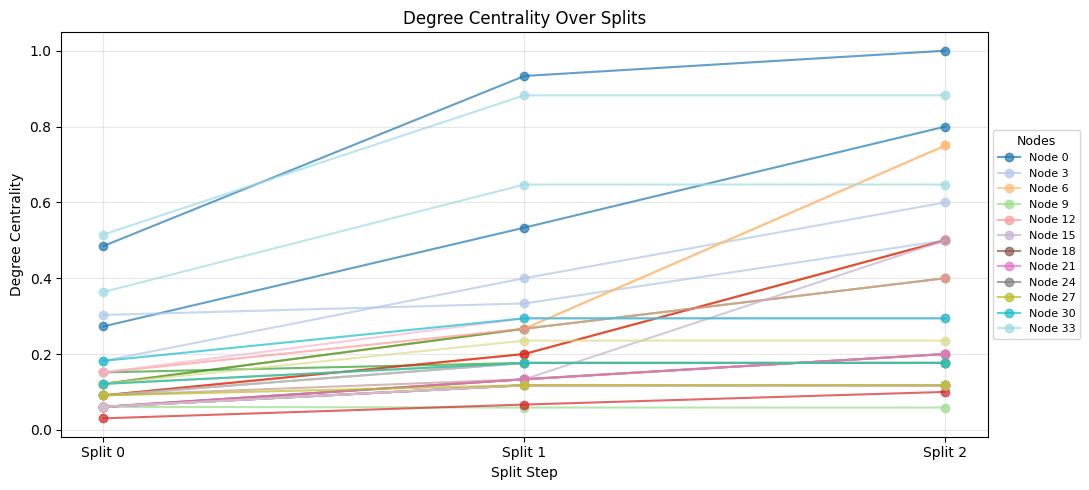

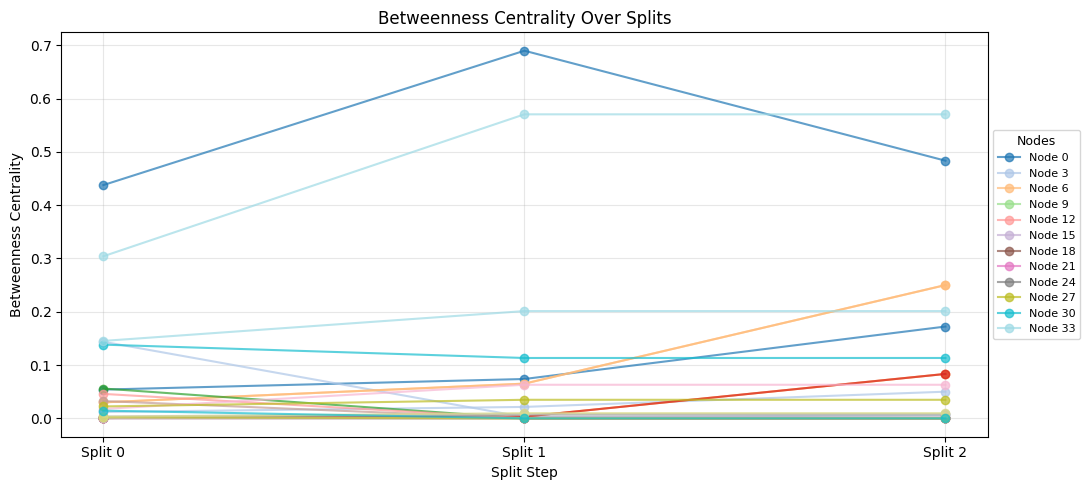

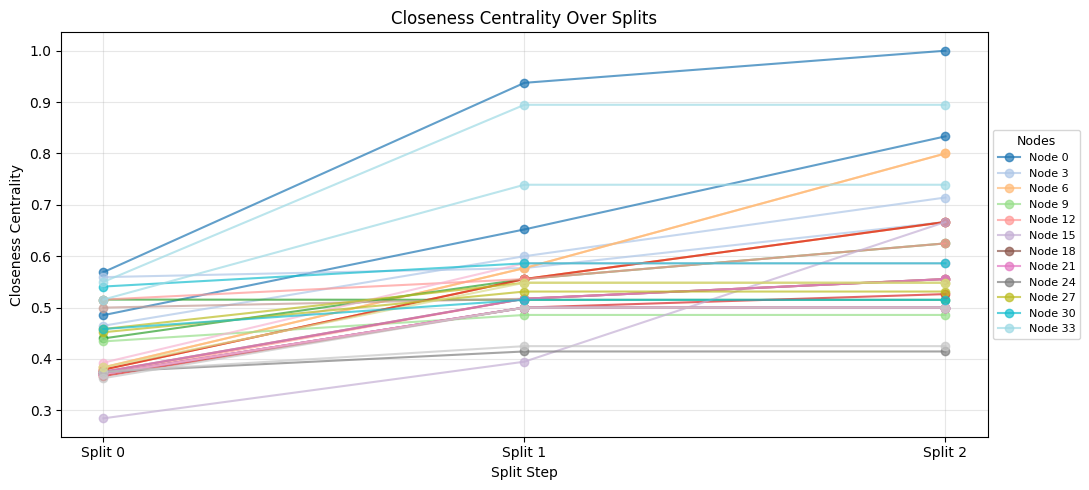

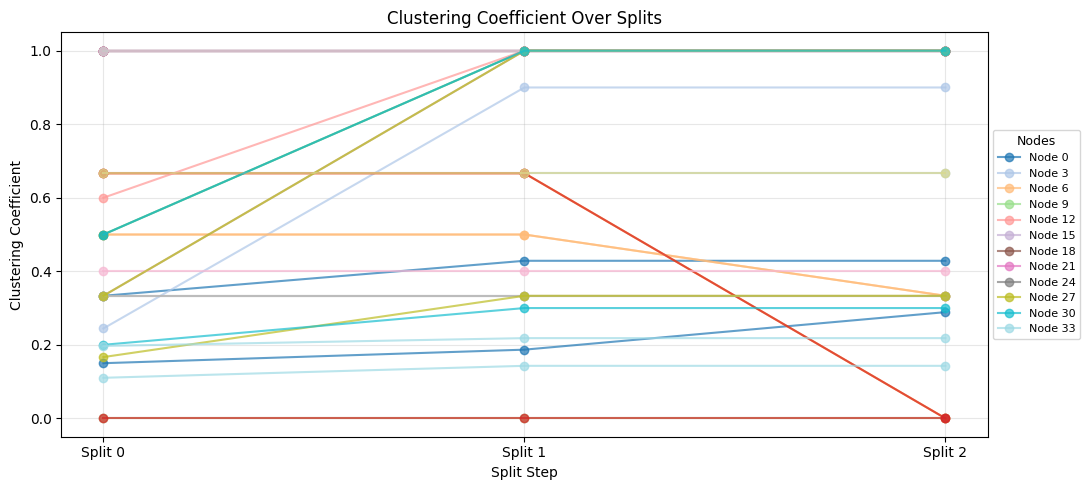

In [6]:
# ================================================================
# ======================== CENTRALITY PLOTS =======================
# ================================================================

steps = [0, 1, 2]

def plot_metric(key, ylabel):
    plt.figure(figsize=(11, 5))

    # Create a color map for better visualization
    colors = plt.cm.tab20(np.linspace(0, 1, len(G.nodes())))

    # Plot each node with its own color
    for i, n in enumerate(sorted(G.nodes())):
        plt.plot(steps, metrics_history[key][n], marker='o', linewidth=1.5,
                color=colors[i], label=f'Node {n}', alpha=0.7)

    plt.xticks(steps, ["Split 0", "Split 1", "Split 2"])
    plt.xlabel("Split Step")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} Over Splits")
    plt.grid(True, alpha=0.3)

    # Add legend but limit to show only some nodes to avoid clutter
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels) > 15:  # If too many nodes, show only every 3rd node in legend
        plt.legend(handles[::3], labels[::3], loc='center left', bbox_to_anchor=(1, 0.5),
                  title="Nodes", fontsize=8, title_fontsize=9)
    else:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                  title="Nodes", fontsize=8, title_fontsize=9)

    plt.tight_layout()
    plt.show()


plot_metric('degree', 'Degree Centrality')
plot_metric('betweenness', 'Betweenness Centrality')
plot_metric('closeness', 'Closeness Centrality')
plot_metric('clustering', 'Clustering Coefficient')